## Making Window

In [ ]:
import os
import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/Raw DataSet.csv')

def parse_positive_sites(positive_sites_str):
    """Convert a space-separated string of positive sites into a list of integers."""
    try:
        return list(map(int, positive_sites_str.split()))
    except ValueError:
        print(f"Warning: Unable to parse positive sites from '{positive_sites_str}'")
        return []

def generate_windows_and_labels(sequence, positivesites, window_size):
    """Generate windows centered on K and label them."""
    windows = []
    labels = []

    half_window = window_size // 2

    for i in range(half_window, len(sequence) - half_window):
        if sequence[i] == 'K':
            window = sequence[i - half_window:i + half_window + 1]
            label = 1 if (i + 1) in positivesites else 0
            windows.append(window)
            labels.append(label)

    return windows, labels

# Define the specific window size
window_size = 21

# Create a directory to save the CSV files
output_dir = '/content/Window_21'
os.makedirs(output_dir, exist_ok=True)

# Initialize lists to store all windows and labels
all_windows = []
all_labels = []

# Process each sequence in the DataFrame
for index, row in df.iterrows():
    sequence = row.get('Seq', '')
    positivesites = parse_positive_sites(row.get('PositiveSite', ''))
    if sequence and positivesites:
        windows, labels = generate_windows_and_labels(sequence, positivesites, window_size)
        all_windows.extend(windows)
        all_labels.extend(labels)

# Create a DataFrame with windows and labels
windows_df = pd.DataFrame({'Window': all_windows, 'Label': all_labels})

# Save the DataFrame to a CSV file
csv_file_path = os.path.join(output_dir, f'labeled_windows_{window_size}.csv')
windows_df.to_csv(csv_file_path, index=False)

# Print the first few rows of the DataFrame
print(f"Window size {window_size}:")
print(windows_df.head())

print("Labeled windows have been saved to the corresponding folder.")


Window size 21:
                  Window  Label
0  EHEEVAQRVIKLHRGRGVAAM      0
1  SRQWVRDSCRKLSGLLRQKNA      0
2  CRKLSGLLRQKNAVLNKLKTA      0
3  LLRQKNAVLNKLKTAIGAVEK      0
4  RQKNAVLNKLKTAIGAVEKDV      0
Labeled windows have been saved to the corresponding folder.


X_train_combined shape: (35400, 420)
y_train shape: (35400,)
X_test_combined shape: (8850, 420)
y_test shape: (8850,)

Random Forest Model Report:
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Accuracy: 0.6662146892655367


<ipython-input-6-fb15802d7629>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=report_df, palette='viridis')


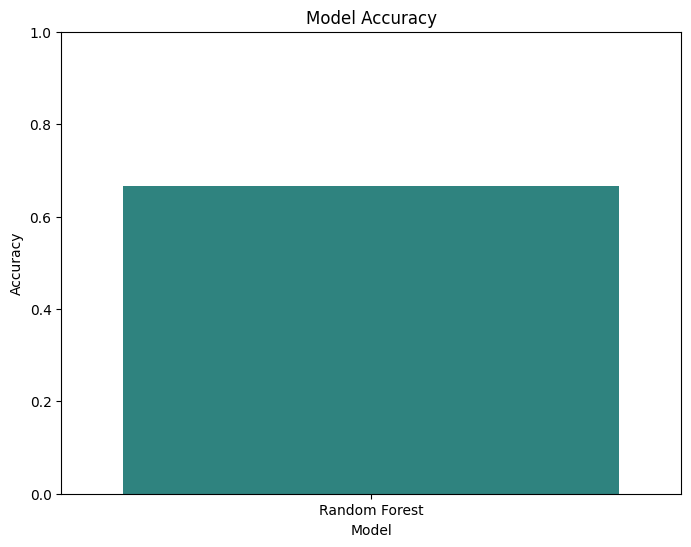

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Fixed list of 20 standard amino acids
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

# Function to compute AAC features
def aac_compute(seq):
    seq = seq.replace('^', '')  # Remove '^' character if present
    aa_counts = Counter(seq)
    total_aa = len(seq)
    aa_percentages = [(aa_counts[aa] / total_aa) * 100 if total_aa > 0 else 0 for aa in amino_acids]
    return [round(v, 2) for v in aa_percentages]  # Round to two decimal places

# Function to compute DPC features
def dpc_compute(seq):
    seq = seq.replace('^', '')  # Remove '^' character if present
    total_pairs = len(seq) - 1
    pair_counts = Counter([seq[i:i+2] for i in range(len(seq)-1)])
    pair_frequencies = [(pair_counts[aa1+aa2] / total_pairs) * 100 if total_pairs > 0 else 0 for aa1 in amino_acids for aa2 in amino_acids]
    return [round(v, 2) for v in pair_frequencies]  # Round to two decimal places

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

# Load your training dataset
train_data = pd.read_csv('/content/training_set_21.csv')

# Extract sequences and labels for training
X_train = train_data['Window']
y_train = train_data['Label']

# Drop rows where y is NaN
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()

# Compute AAC and DPC features for each sequence in X_train
X_train_aac = np.array(X_train.apply(aac_compute).tolist())
X_train_dpc = np.array(X_train.apply(dpc_compute).tolist())
X_train_combined = np.concatenate((X_train_aac, X_train_dpc), axis=1)

print("X_train_combined shape:", X_train_combined.shape)
print("y_train shape:", y_train.shape)

# Load your test dataset
test_data = pd.read_csv('/content/test_set_21.csv')

# Extract sequences and labels for testing
X_test = test_data['Window']
y_test = test_data['Label']

# Compute AAC and DPC features for each sequence in X_test
X_test_aac = np.array(X_test.apply(aac_compute).tolist())
X_test_dpc = np.array(X_test.apply(dpc_compute).tolist())
X_test_combined = np.concatenate((X_test_aac, X_test_dpc), axis=1)

print("X_test_combined shape:", X_test_combined.shape)
print("y_test shape:", y_test.shape)

# Define the Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model on the combined features
model.fit(X_train_combined, y_train)

# Evaluate the model on the test data
accuracy = evaluate_model(model, X_test_combined, y_test)

# Print the model report
print(f"\nRandom Forest Model Report:")
print(f"Parameters: {model.get_params()}")
print(f"Accuracy: {accuracy}")

# Create a DataFrame for the model report
report_df = pd.DataFrame({'Model': ['Random Forest'], 'Accuracy': [accuracy]})

# Plot the accuracy
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=report_df, palette='viridis')
plt.title('Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Save the report to a CSV file
report_df.to_csv('model_report_table.csv', index=False)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load your dataset
data = pd.read_csv('/content/labeled_windows_21.csv')

# Extract sequences and labels
X = data['Window']
y = data['Label']

# Combine features and labels into a single DataFrame
data = pd.DataFrame({'Window': X, 'Label': y})

# Separate data by class
class_0 = data[data['Label'] == 0]
class_1 = data[data['Label'] == 1]

# Find the number of samples in each class
num_class_0 = len(class_0)
num_class_1 = len(class_1)

# Determine the desired class sizes for a 2:1 ratio
desired_class_1_size = num_class_1
desired_class_0_size = 2 * desired_class_1_size

# Sample the data to achieve the desired ratio
if desired_class_0_size > num_class_0:
    print(f"Warning: Not enough class_0 samples. Reducing to maximum available ({num_class_0})")
    desired_class_0_size = num_class_0

class_0_balanced = class_0.sample(n=desired_class_0_size, random_state=42)
class_1_balanced = class_1.sample(n=desired_class_1_size, random_state=42)

# Combine the balanced data
balanced_data = pd.concat([class_0_balanced, class_1_balanced])

# Shuffle the balanced dataset
balanced_data = shuffle(balanced_data, random_state=42)

# Extract balanced features and labels
X_balanced = balanced_data['Window']
y_balanced = balanced_data['Label']

# Split the balanced dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Combine features and labels for saving
train_set = pd.DataFrame({'Window': X_train, 'Label': y_train})
test_set = pd.DataFrame({'Window': X_test, 'Label': y_test})

# Save the datasets to CSV files
train_set.to_csv('/content/training_set_21.csv', index=False)
test_set.to_csv('/content/test_set_21.csv', index=False)

# Print shapes of resulting sets
print(f"Training data shape: {train_set.shape}, Training labels shape: {train_set['Label'].shape}")
print(f"Test data shape: {test_set.shape}, Test labels shape: {test_set['Label'].shape}")


Training data shape: (24542, 2), Training labels shape: (24542,)
Test data shape: (6136, 2), Test labels shape: (6136,)


## Multiple Models


In [ ]:
import pandas as pd
import numpy as np
from itertools import product
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import tensorflow as tf

# Fixed list of 20 standard amino acids
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

# Function to compute AAC features
def aac_compute(seq):
    seq = seq.replace('^', '')  # Remove '^' character if present
    aa_counts = Counter(seq)
    total_aa = len(seq)
    aa_percentages = [(aa_counts[aa] / total_aa) * 100 if total_aa > 0 else 0 for aa in amino_acids]
    return [round(v, 2) for v in aa_percentages]  # Round to two decimal places

# Function to compute DPC features
def dpc_compute(seq):
    seq = seq.replace('^', '')  # Remove '^' character if present
    total_pairs = len(seq) - 1
    pair_counts = Counter([seq[i:i+2] for i in range(len(seq)-1)])
    pair_frequencies = [(pair_counts[aa1+aa2] / total_pairs) * 100 if total_pairs > 0 else 0 for aa1 in amino_acids for aa2 in amino_acids]
    return [round(v, 2) for v in pair_frequencies]  # Round to two decimal places

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

# Load your training dataset
train_data = pd.read_csv('/content/training_set_21.csv')

# Extract sequences and labels for training
X_train = train_data['Window']
y_train = train_data['Label']

# Drop rows where y is NaN
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()

# Compute AAC and DPC features for each sequence in X_train
X_train_aac = np.array(X_train.apply(aac_compute).tolist())
X_train_dpc = np.array(X_train.apply(dpc_compute).tolist())
X_train_combined = np.concatenate((X_train_aac, X_train_dpc), axis=1)

print("X_train_combined shape:", X_train_combined.shape)
print("y_train shape:", y_train.shape)

# Load your test dataset
test_data = pd.read_csv('/content/test_set_21.csv')

# Extract sequences and labels for testing
X_test = test_data['Window']
y_test = test_data['Label']

# Compute AAC and DPC features for each sequence in X_test
X_test_aac = np.array(X_test.apply(aac_compute).tolist())
X_test_dpc = np.array(X_test.apply(dpc_compute).tolist())
X_test_combined = np.concatenate((X_test_aac, X_test_dpc), axis=1)

print("X_test_combined shape:", X_test_combined.shape)
print("y_test shape:", y_test.shape)

# Initialize and train a RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_combined, y_train)

# Initialize and train a KNeighborsClassifier with grid search for hyperparameter tuning
knn_param_grid = {'n_neighbors': list(range(3, 10))}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid)
knn_grid_search.fit(X_train_combined, y_train)
knn_model = knn_grid_search.best_estimator_

# Initialize and train an XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train_combined, y_train)

# Define and train the DNN model
dnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_combined.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # Assuming 2 classes for binary classification
])

# Compile the model
dnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' for integer labels
                  metrics=['accuracy'])

# Train the model
history = dnn_model.fit(X_train_combined, y_train, epochs=80, batch_size=32, validation_split=0.2, verbose=0)

# Predict labels for test data
rf_pred = rf_classifier.predict(X_test_combined)
knn_pred = knn_model.predict(X_test_combined)
xgb_pred = xgb_model.predict(X_test_combined)
dnn_pred = np.argmax(dnn_model.predict(X_test_combined), axis=-1)

# Evaluate model performance using accuracy_score
rf_accuracy = accuracy_score(y_test, rf_pred)
knn_accuracy = accuracy_score(y_test, knn_pred)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
dnn_accuracy = accuracy_score(y_test, dnn_pred)

# Print accuracy scores for each model
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"KNN Accuracy: {knn_accuracy}")
print(f"XGBoost Accuracy: {xgb_accuracy}")
print(f"DNN Accuracy: {dnn_accuracy}")


X_train_combined shape: (24542, 420)
y_train shape: (24542,)
X_test_combined shape: (6136, 420)
y_test shape: (6136,)
192/192 [==============================] - 0s 2ms/step
Random Forest Accuracy: 0.6760104302477183
KNN Accuracy: 0.6577574967405476
XGBoost Accuracy: 0.6808996088657105
DNN Accuracy: 0.6395045632333768


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Fixed list of 20 standard amino acids
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

# Function to compute AAC features
def aac_compute(seq):
    seq = seq.replace('^', '')  # Remove '^' character if present
    aa_counts = Counter(seq)
    total_aa = len(seq)
    aa_percentages = [(aa_counts[aa] / total_aa) * 100 if total_aa > 0 else 0 for aa in amino_acids]
    return [round(v, 2) for v in aa_percentages]  # Round to two decimal places

# Function to compute DPC features
def dpc_compute(seq):
    seq = seq.replace('^', '')  # Remove '^' character if present
    total_pairs = len(seq) - 1
    pair_counts = Counter([seq[i:i+2] for i in range(len(seq)-1)])
    pair_frequencies = [(pair_counts[aa1+aa2] / total_pairs) * 100 if total_pairs > 0 else 0 for aa1 in amino_acids for aa2 in amino_acids]
    return [round(v, 2) for v in pair_frequencies]  # Round to two decimal places

# Load your training dataset
train_data = pd.read_csv('/content/training_set_21.csv')

# Extract sequences and labels for training
X_train = train_data['Window']
y_train = train_data['Label']

# Drop rows where y is NaN
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()

# Compute AAC and DPC features for each sequence in X_train
X_train_aac = np.array(X_train.apply(aac_compute).tolist())
X_train_dpc = np.array(X_train.apply(dpc_compute).tolist())
X_train_combined = np.concatenate((X_train_aac, X_train_dpc), axis=1)

print("X_train_combined shape:", X_train_combined.shape)
print("y_train shape:", y_train.shape)

# Load your test dataset
test_data = pd.read_csv('/content/test_set_21.csv')

# Extract sequences and labels for testing
X_test = test_data['Window']
y_test = test_data['Label']

# Compute AAC and DPC features for each sequence in X_test
X_test_aac = np.array(X_test.apply(aac_compute).tolist())
X_test_dpc = np.array(X_test.apply(dpc_compute).tolist())
X_test_combined = np.concatenate((X_test_aac, X_test_dpc), axis=1)

print("X_test_combined shape:", X_test_combined.shape)
print("y_test shape:", y_test.shape)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_combined, y_train)

# Get the best estimator
best_rf_classifier = grid_search.best_estimator_

# Predict labels for test data using the best model
rf_pred = best_rf_classifier.predict(X_test_combined)

# Evaluate model performance using accuracy_score
rf_accuracy = accuracy_score(y_test, rf_pred)

# Print the best parameters and accuracy score
print(f"Best Random Forest Parameters: {grid_search.best_params_}")
print(f"Random Forest Accuracy: {rf_accuracy}")


X_train_combined shape: (24542, 420)
y_train shape: (24542,)
X_test_combined shape: (6136, 420)
y_test shape: (6136,)
Fitting 5 folds for each of 540 candidates, totalling 2700 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Fixed list of 20 standard amino acids
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

# Function to compute AAC features
def aac_compute(seq):
    seq = seq.replace('^', '')  # Remove '^' character if present
    aa_counts = Counter(seq)
    total_aa = len(seq)
    aa_percentages = [(aa_counts[aa] / total_aa) * 100 if total_aa > 0 else 0 for aa in amino_acids]
    return [round(v, 2) for v in aa_percentages]  # Round to two decimal places

# Function to compute DPC features
def dpc_compute(seq):
    seq = seq.replace('^', '')  # Remove '^' character if present
    total_pairs = len(seq) - 1
    pair_counts = Counter([seq[i:i+2] for i in range(len(seq)-1)])
    pair_frequencies = [(pair_counts[aa1+aa2] / total_pairs) * 100 if total_pairs > 0 else 0 for aa1 in amino_acids for aa2 in amino_acids]
    return [round(v, 2) for v in pair_frequencies]  # Round to two decimal places

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

# Load your training dataset
train_data = pd.read_csv('/content/training_set_21.csv')

# Extract sequences and labels for training
X_train = train_data['Window']
y_train = train_data['Label']

# Drop rows where y is NaN
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()

# Compute AAC features for each sequence in X_train
X_train_aac = np.array(X_train.apply(aac_compute).tolist())

# Compute DPC features for each sequence in X_train
X_train_dpc = np.array(X_train.apply(dpc_compute).tolist())

# Load your test dataset
test_data = pd.read_csv('/content/test_set_21.csv')

# Extract sequences and labels for testing
X_test = test_data['Window']
y_test = test_data['Label']

# Compute AAC features for each sequence in X_test
X_test_aac = np.array(X_test.apply(aac_compute).tolist())

# Compute DPC features for each sequence in X_test
X_test_dpc = np.array(X_test.apply(dpc_compute).tolist())

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Function to perform GridSearchCV and evaluate the model
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, param_grid):
    rf_classifier = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_rf_classifier = grid_search.best_estimator_
    rf_pred = best_rf_classifier.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    print(f"Best Random Forest Parameters: {grid_search.best_params_}")
    return rf_accuracy

# Evaluate model with AAC features
print("Evaluating model with AAC features...")
rf_accuracy_aac = train_and_evaluate_rf(X_train_aac, y_train, X_test_aac, y_test, param_grid)
print(f"Random Forest Accuracy with AAC features: {rf_accuracy_aac}")

# Evaluate model with DPC features
print("Evaluating model with DPC features...")
rf_accuracy_dpc = train_and_evaluate_rf(X_train_dpc, y_train, X_test_dpc, y_test, param_grid)
print(f"Random Forest Accuracy with DPC features: {rf_accuracy_dpc}")


## ACCURACY USING EACH Feature Extraction Technique

RandomForest Best Params: {'max_depth': 12, 'n_estimators': 100}
RandomForest Accuracy (AAC): 0.6746791607251986
RandomForest F1 Score (AAC): 0.4661680440990825
KNN Best Params: {'n_neighbors': 9}
KNN Accuracy (AAC): 0.628844978610715
KNN F1 Score (AAC): 0.5373561149367354


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:00:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:00:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:00:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:00:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:00:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Best Params: {'max_depth': 10, 'n_estimators': 100}
XGBoost Accuracy (AAC): 0.6549195355469546
XGBoost F1 Score (AAC): 0.5755305252085227
Epoch 1/80
491/491 [==============================] - 3s 3ms/step - loss: 0.8910 - accuracy: 0.6071 - val_loss: 0.6274 - val_accuracy: 0.6751
Epoch 2/80
491/491 [==============================] - 2s 3ms/step - loss: 0.6378 - accuracy: 0.6573 - val_loss: 0.6202 - val_accuracy: 0.6751
Epoch 3/80
491/491 [==============================] - 2s 5ms/step - loss: 0.6247 - accuracy: 0.6623 - val_loss: 0.6141 - val_accuracy: 0.6751
Epoch 4/80
491/491 [==============================] - 2s 4ms/step - loss: 0.6174 - accuracy: 0.6633 - val_loss: 0.6088 - val_accuracy: 0.6751
Epoch 5/80
491/491 [==============================] - 1s 3ms/step - loss: 0.6131 - accuracy: 0.6629 - val_loss: 0.6089 - val_accuracy: 0.6751
Epoch 6/80
491/491 [==============================] - 1s 3ms/step - loss: 0.6090 - accuracy: 0.6629 - val_loss: 0.6027 - val_accuracy: 0.6751
Ep

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:04:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:04:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:04:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:04:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:04:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Best Params: {'max_depth': 12, 'n_estimators': 100}
XGBoost Accuracy (DPC): 0.6622530046852719
XGBoost F1 Score (DPC): 0.5665153318869502
Epoch 1/80
491/491 [==============================] - 3s 4ms/step - loss: 0.7807 - accuracy: 0.6174 - val_loss: 0.6252 - val_accuracy: 0.6751
Epoch 2/80
491/491 [==============================] - 2s 3ms/step - loss: 0.6340 - accuracy: 0.6587 - val_loss: 0.6160 - val_accuracy: 0.6756
Epoch 3/80
491/491 [==============================] - 3s 5ms/step - loss: 0.6105 - accuracy: 0.6634 - val_loss: 0.6094 - val_accuracy: 0.6751
Epoch 4/80
491/491 [==============================] - 4s 7ms/step - loss: 0.5969 - accuracy: 0.6710 - val_loss: 0.6053 - val_accuracy: 0.6763
Epoch 5/80
491/491 [==============================] - 4s 7ms/step - loss: 0.5825 - accuracy: 0.6813 - val_loss: 0.5983 - val_accuracy: 0.6763
Epoch 6/80
491/491 [==============================] - 2s 5ms/step - loss: 0.5697 - accuracy: 0.6901 - val_loss: 0.6012 - val_accuracy: 0.6766
Ep

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:08:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:08:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:08:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:08:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:08:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Best Params: {'max_depth': 10, 'n_estimators': 100}
XGBoost Accuracy (One-Hot): 0.6549195355469546
XGBoost F1 Score (One-Hot): 0.5755305252085227
Epoch 1/80
491/491 [==============================] - 3s 3ms/step - loss: 0.6625 - accuracy: 0.6328 - val_loss: 0.6052 - val_accuracy: 0.6751
Epoch 2/80
491/491 [==============================] - 1s 3ms/step - loss: 0.6181 - accuracy: 0.6616 - val_loss: 0.6018 - val_accuracy: 0.6746
Epoch 3/80
491/491 [==============================] - 1s 3ms/step - loss: 0.6091 - accuracy: 0.6648 - val_loss: 0.5950 - val_accuracy: 0.6748
Epoch 4/80
491/491 [==============================] - 2s 4ms/step - loss: 0.6023 - accuracy: 0.6650 - val_loss: 0.5914 - val_accuracy: 0.6784
Epoch 5/80
491/491 [==============================] - 2s 4ms/step - loss: 0.5972 - accuracy: 0.6701 - val_loss: 0.5886 - val_accuracy: 0.6763
Epoch 6/80
491/491 [==============================] - 1s 3ms/step - loss: 0.5934 - accuracy: 0.6739 - val_loss: 0.5854 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:12:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:12:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:12:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:12:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Best Params: {'max_depth': 12, 'n_estimators': 100}
XGBoost Accuracy (TF-IDF): 0.6553269504990833
XGBoost F1 Score (TF-IDF): 0.573802258050215
Epoch 1/80
491/491 [==============================] - 3s 4ms/step - loss: 0.6276 - accuracy: 0.6640 - val_loss: 0.6038 - val_accuracy: 0.6771
Epoch 2/80
491/491 [==============================] - 1s 3ms/step - loss: 0.6104 - accuracy: 0.6618 - val_loss: 0.5951 - val_accuracy: 0.6784
Epoch 3/80
491/491 [==============================] - 2s 5ms/step - loss: 0.5998 - accuracy: 0.6678 - val_loss: 0.5912 - val_accuracy: 0.6771
Epoch 4/80
491/491 [==============================] - 2s 4ms/step - loss: 0.5971 - accuracy: 0.6650 - val_loss: 0.5872 - val_accuracy: 0.6804
Epoch 5/80
491/491 [==============================] - 1s 3ms/step - loss: 0.5910 - accuracy: 0.6723 - val_loss: 0.5867 - val_accuracy: 0.6822
Epoch 6/80
491/491 [==============================] - 1s 3ms/step - loss: 0.5889 - accuracy: 0.6752 - val_loss: 0.5852 - val_accuracy: 0.68

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:17:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:17:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:17:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:17:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:17:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Best Params: {'max_depth': 12, 'n_estimators': 100}
XGBoost Accuracy (Bag of Words): 0.6622530046852719
XGBoost F1 Score (Bag of Words): 0.5665153318869502
Epoch 1/80
491/491 [==============================] - 4s 6ms/step - loss: 0.6370 - accuracy: 0.6561 - val_loss: 0.6111 - val_accuracy: 0.6751
Epoch 2/80
491/491 [==============================] - 2s 4ms/step - loss: 0.6077 - accuracy: 0.6650 - val_loss: 0.5990 - val_accuracy: 0.6781
Epoch 3/80
491/491 [==============================] - 2s 4ms/step - loss: 0.5901 - accuracy: 0.6769 - val_loss: 0.5977 - val_accuracy: 0.6761
Epoch 4/80
491/491 [==============================] - 2s 4ms/step - loss: 0.5709 - accuracy: 0.6912 - val_loss: 0.5971 - val_accuracy: 0.6789
Epoch 5/80
491/491 [==============================] - 2s 4ms/step - loss: 0.5540 - accuracy: 0.7128 - val_loss: 0.5993 - val_accuracy: 0.6771
Epoch 6/80
491/491 [==============================] - 2s 4ms/step - loss: 0.5281 - accuracy: 0.7321 - val_loss: 0.6042 - val_a

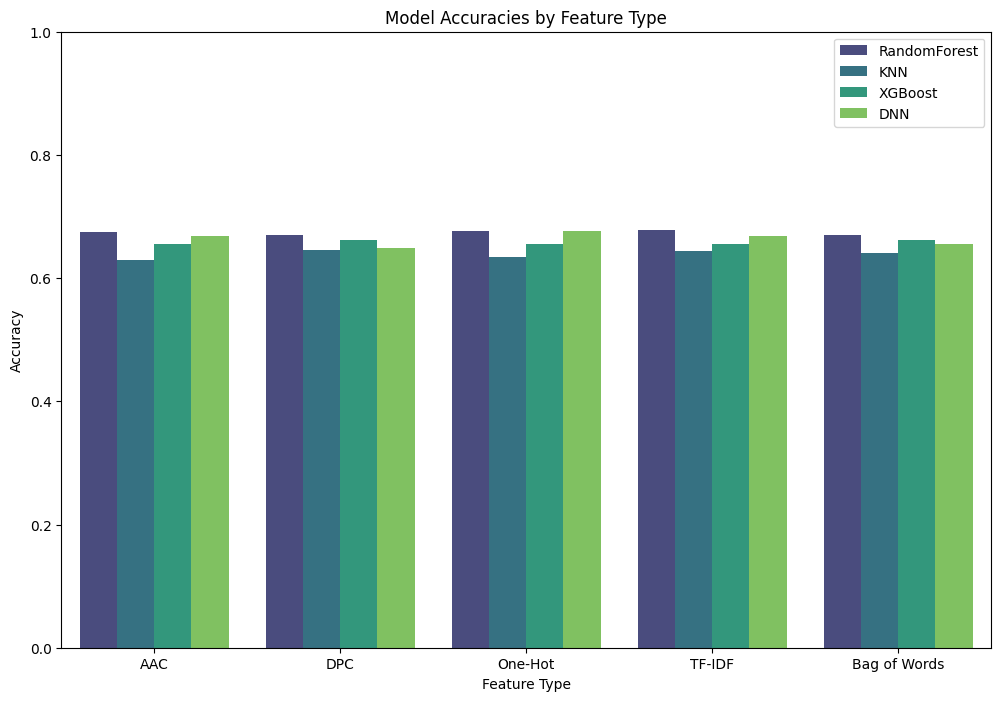

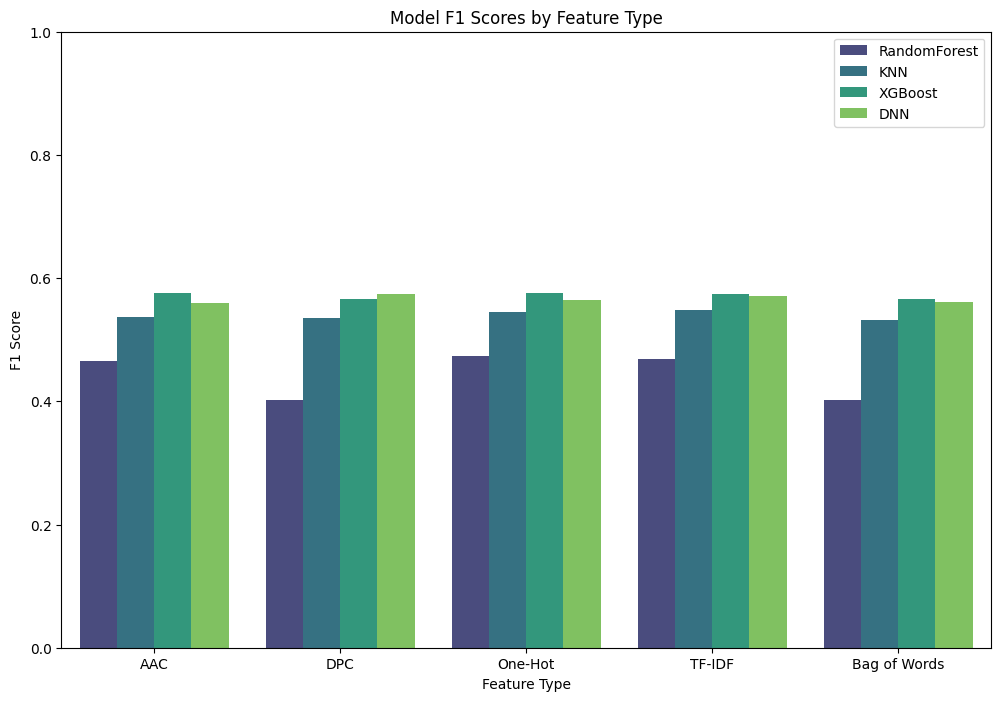

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Fixed list of 20 standard amino acids
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

# Function to compute AAC features
def aac_compute(seq):
    seq = str(seq).replace('^', '')  # Convert to string and remove '^' character if present
    aa_counts = Counter(seq)
    total_aa = len(seq)
    aa_percentages = [(aa_counts[aa] / total_aa) * 100 if total_aa > 0 else 0 for aa in amino_acids]
    return [round(v, 2) for v in aa_percentages]  # Round to two decimal places

# Function to compute DPC features
def dpc_compute(seq):
    seq = str(seq).replace('^', '')  # Convert to string and remove '^' character if present
    total_pairs = len(seq) - 1
    pair_counts = Counter([seq[i:i+2] for i in range(len(seq)-1)])
    pair_frequencies = [(pair_counts[aa1+aa2] / total_pairs) * 100 if total_pairs > 0 else 0 for aa1 in amino_acids for aa2 in amino_acids]
    return [round(v, 2) for v in pair_frequencies]  # Round to two decimal places

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    return accuracy_score(y_test, predictions), f1_score(y_test, predictions, average='macro')

# Function to create DNN model
def create_dnn(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Load your dataset
data = pd.read_csv('/content/training_set_21.csv')

# Extract sequences and labels
X = data['Window'].astype(str)
y = data['Label']

# Compute AAC and DPC features for each sequence
X_aac = np.array([aac_compute(seq) for seq in X])
X_dpc = np.array([dpc_compute(seq) for seq in X])

# One-Hot Encoding
onehot_encoder = CountVectorizer(analyzer='char', ngram_range=(1, 1))
X_onehot = onehot_encoder.fit_transform(X).toarray()

# TF-IDF Encoding
tfidf_encoder = TfidfVectorizer(analyzer='char', ngram_range=(1, 1))
X_tfidf = tfidf_encoder.fit_transform(X).toarray()

# Bag of Words
bow_encoder = CountVectorizer(analyzer='char', ngram_range=(2, 2))  # Using bigrams for BoW
X_bow = bow_encoder.fit_transform(X).toarray()

# Split data into training and test sets
X_train_aac, X_test_aac, y_train, y_test = train_test_split(X_aac, y, test_size=0.2, random_state=42)
X_train_dpc, X_test_dpc, _, _ = train_test_split(X_dpc, y, test_size=0.2, random_state=42)
X_train_onehot, X_test_onehot, _, _ = train_test_split(X_onehot, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_bow, X_test_bow, _, _ = train_test_split(X_bow, y, test_size=0.2, random_state=42)

# Model definitions and hyperparameters
models = {
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    'RandomForest': {'n_estimators': [100], 'max_depth': [10, 12]},
    'KNN': {'n_neighbors': [3, 5, 7, 9]},
    'XGBoost': {'n_estimators': [100], 'max_depth': [10, 12]}
}

# Function to train and evaluate models on a specific feature set
def train_evaluate_feature_set(X_train, X_test, y_train, y_test, feature_name):
    results = {}
    for model_name, model in models.items():
        grid_search = GridSearchCV(model, param_grids[model_name], scoring='accuracy', cv=5)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        accuracy, f1 = evaluate_model(best_model, X_test, y_test)
        results[model_name] = {'accuracy': accuracy, 'f1_score': f1}
        print(f"{model_name} Best Params: {grid_search.best_params_}")
        print(f"{model_name} Accuracy ({feature_name}): {accuracy}")
        print(f"{model_name} F1 Score ({feature_name}): {f1}")

    # Train and evaluate DNN model
    input_dim = X_train.shape[1]
    dnn_model = create_dnn(input_dim)
    dnn_model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.2, verbose=1)
    dnn_predictions = np.argmax(dnn_model.predict(X_test), axis=1)
    dnn_accuracy = accuracy_score(y_test, dnn_predictions)
    dnn_f1 = f1_score(y_test, dnn_predictions, average='macro')
    results['DNN'] = {'accuracy': dnn_accuracy, 'f1_score': dnn_f1}
    print(f"DNN Accuracy ({feature_name}): {dnn_accuracy}")
    print(f"DNN F1 Score ({feature_name}): {dnn_f1}")

    return results

# Train and evaluate models on each feature set
results_aac = train_evaluate_feature_set(X_train_aac, X_test_aac, y_train, y_test, 'AAC')
results_dpc = train_evaluate_feature_set(X_train_dpc, X_test_dpc, y_train, y_test, 'DPC')
results_onehot = train_evaluate_feature_set(X_train_onehot, X_test_onehot, y_train, y_test, 'One-Hot')
results_tfidf = train_evaluate_feature_set(X_train_tfidf, X_test_tfidf, y_train, y_test, 'TF-IDF')
results_bow = train_evaluate_feature_set(X_train_bow, X_test_bow, y_train, y_test, 'Bag of Words')

# Combine all results into a DataFrame for visualization
all_results = []
for feature, results in zip(['AAC', 'DPC', 'One-Hot', 'TF-IDF', 'Bag of Words'],
                            [results_aac, results_dpc, results_onehot, results_tfidf, results_bow]):
    for model_name, metrics in results.items():
        all_results.append({'Feature': feature, 'Model': model_name, 'Accuracy': metrics['accuracy'], 'F1_Score': metrics['f1_score']})

results_df = pd.DataFrame(all_results)

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x='Feature', y='Accuracy', hue='Model', data=results_df, palette='viridis')
plt.title('Model Accuracies by Feature Type')
plt.xlabel('Feature Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Feature', y='F1_Score', hue='Model', data=results_df, palette='viridis')
plt.title('Model F1 Scores by Feature Type')
plt.xlabel('Feature Type')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

# Save the results to a CSV file
results_df.to_csv('model_accuracies_f1_scores.csv', index=False)
